# Exploratory Data Analysis

---

Yelp has challenged Kagglers to build a model that automatically tags restaurants with multiple labels using a dataset of user-submitted photos. Currently, restaurant labels are manually selected by Yelp users when they submit a review. Selecting the labels is optional, leaving some restaurants un- or only partially-categorized.

The datasets can be downloaded on Kaggle: https://www.kaggle.com/c/yelp-restaurant-photo-classification. An exploratory data analysis of these data is performed below.

## 1. Load Files

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
from common import encode_label

sns.set_style("whitegrid")
%matplotlib inline

# Business id to labels
df = pd.read_csv('data/train.csv', header = 0, names = ['business','labels']).fillna('')

# Photo id to business id for the training dataset
photo2biz_train = pd.read_csv('data/train_photo_to_biz_ids.csv', header = 0, names = ['photo','business'])

# Photo id to business id for the test dataset
photo2biz_test = pd.read_csv('data/test_photo_to_biz.csv', header = 0, names = ['photo','business'])

Using TensorFlow backend.


## 2. Data Processing

The `train.csv` file maps `business` to `labels`. There are nine different labels:
* 0 = good_for_lunch
* 1 = good_for_dinner
* 2 = takes_reservations
* 3 = outdoor_seating
* 4 = restaurant_is_expensive
* 5 = has_alcohol
* 6 = has_table_service
* 7 = ambience_is_classy
* 8 = good_for_kids

The original data frame is slightly modified to better access the labels associated to each business.

In [2]:
df['labels'] = df['labels'].apply(lambda x: tuple(sorted(int(t) for t in x.split())))
df.set_index('business', inplace=True)

df.head(n=10)

labels
business                       
1000      (1, 2, 3, 4, 5, 6, 7)
1001               (0, 1, 6, 8)
100          (1, 2, 4, 5, 6, 7)
1006            (1, 2, 4, 5, 6)
1010                  (0, 6, 8)
101          (1, 2, 3, 4, 5, 6)
1011               (2, 3, 5, 6)
1012            (1, 2, 3, 5, 6)
1014            (1, 2, 4, 5, 6)
1015               (1, 5, 6, 7)

The `train_photo_to_biz_ids.csv` file maps the photo id (`photo`) to the business id (`business`) for the training dataset. This information is added to the above data frame (`photos`). The total number of photos (`n_photo`) is also included in the table.

In [3]:
biz2photos_train = photo2biz_train.groupby('business')['photo'].apply(list)
df['photos'] = biz2photos_train
df['n_photos'] = biz2photos_train.apply(len)

df.head(n=10)

labels  \
business                          
1000      (1, 2, 3, 4, 5, 6, 7)   
1001               (0, 1, 6, 8)   
100          (1, 2, 4, 5, 6, 7)   
1006            (1, 2, 4, 5, 6)   
1010                  (0, 6, 8)   
101          (1, 2, 3, 4, 5, 6)   
1011               (2, 3, 5, 6)   
1012            (1, 2, 3, 5, 6)   
1014            (1, 2, 4, 5, 6)   
1015               (1, 5, 6, 7)   

                                                     photos  n_photos  
business                                                               
1000      [438623, 325966, 227692, 407856, 368729, 16319...        54  
1001      [298536, 20346, 8457, 308694, 349310, 407838, ...         9  
100       [338465, 328433, 243861, 361777, 127198, 46652...        84  
1006      [46472, 341947, 396253, 75316, 42330, 244095, ...        22  
1010      [118251, 219940, 27517, 8578, 148347, 433559, ...        11  
101       [13736, 393696, 286907, 86169, 243460, 254663,...       121  
1011      [372371, 116870, 411981, 208597, 127752, 18839...        70  
1012      [287385, 232258, 388225, 151345, 417121, 32754...        37  
1014      [407910, 33911, 269241, 374218, 256236, 296370...        32  
1015      [456770, 44056, 128542, 373344, 87938, 148452,...       145

In [4]:
print('There are %d businesses in the training dataset' % len(df))
print('There are %d photos in the training dataset' % df['n_photos'].sum())
print('There are %d photos per business on average' % df['n_photos'].mean())

There are 2000 businesses in the training dataset
There are 234842 photos in the training dataset
There are 117 photos per business on average


The `test_photo_to_biz.csv` file maps the photo id (`photo`) to the business id (`business`) for the test dataset.

In [5]:
biz2photos_test = photo2biz_test.groupby('business')['photo'].apply(list).to_dict()
biz_test = list(biz2photos_test.keys())
print('There are %d businesses in the test dataset.' % len(biz_test))

There are 10000 businesses in the test dataset.


The labels are then encoded using the `encode_label` function.

In [6]:
from collections import OrderedDict

labels = OrderedDict()
labels['0'] = 'good_for_lunch'
labels['1'] = 'good_for_dinner'
labels['2'] = 'takes_reservations'
labels['3'] = 'outdoor_seating'
labels['4'] = 'restaurant_is_expensive'
labels['5'] = 'has_alcohol'
labels['6'] = 'has_table_service'
labels['7'] = 'ambience_is_classy'
labels['8'] = 'good_for_kids'

train_labels = np.vstack(df['labels'].apply(encode_label))

## 3. Visualization

### A. Sample Images
The first 24 photos listed in `photo2biz_train` are desplayed below.

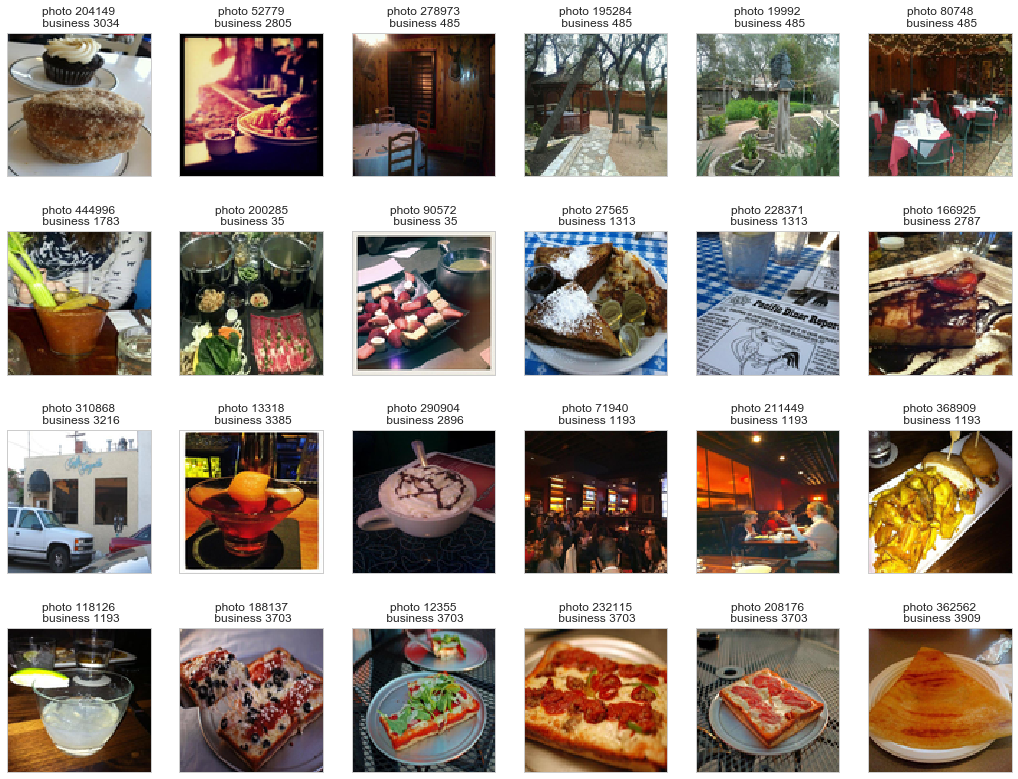

In [7]:
# Display the first 24 images in the training dataset
fig = plt.figure(figsize = (18,14))
for i in range(24):
    img = Image.open('data/train_photos/' + str(photo2biz_train.loc[i][0]) + '.jpg')
    img = img.resize((100, 100), Image.ANTIALIAS)
    ax = fig.add_subplot(4, 6, i+1, xticks = [], yticks = [])
    ax.set_title('photo ' + str(photo2biz_train.loc[i][0]) + '\n business ' + str(photo2biz_train.loc[i][1]))
    ax.imshow(img)

### B. Label Frequency
The histogram of the labels is plotted below. 

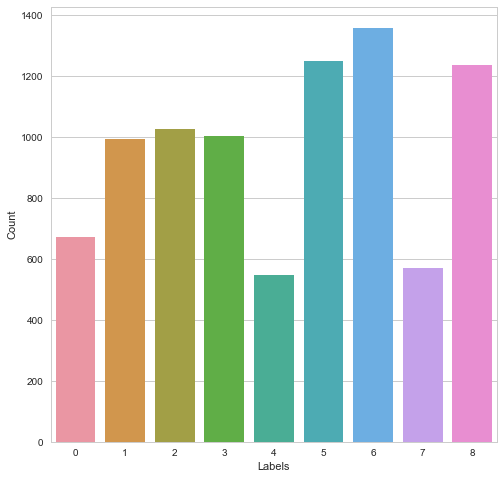

In [8]:
fig = plt.figure(figsize = (8,8))
ax = sns.barplot(x=list(labels.keys()), y=list(np.sum(train_labels, axis = 0)))
ax.set_xlabel('Labels')
ax.set_ylabel('Count')
plt.show()

The least used labels are *good_for_lunch*, *restaurant_is_expensive* and *ambience_is_classy* while the most used labels are *has_alcohol*, *has_table_service* and *good_for_kids*.

### C. Business with Lowest Number of photos

good_for_dinner, takes_reservations, outdoor_seating, restaurant_is_expensive, has_alcohol, has_table_service


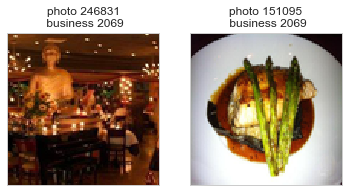

In [9]:
entry = df['n_photos'].argmin()

print(", ".join([labels[str(l)] for l in df.loc[entry]['labels']]))

fig = plt.figure(figsize = (6,4))
for i in range(df.loc[entry].n_photos):
    img = Image.open('data/train_photos/' + str(df.loc[entry]['photos'][i]) + '.jpg')
    img = img.resize((100, 100), Image.ANTIALIAS)
    ax = fig.add_subplot(1, df.loc[entry].n_photos, i+1, xticks = [], yticks = [])
    ax.set_title('photo ' + str(df.loc[entry]['photos'][i]) + '\n business ' + str(entry))
    ax.imshow(img)

### D. Sample Images for each Label
Ten randomly chosen photos for a given label are displayed. Note that the same photo can be associated to multiple labels.

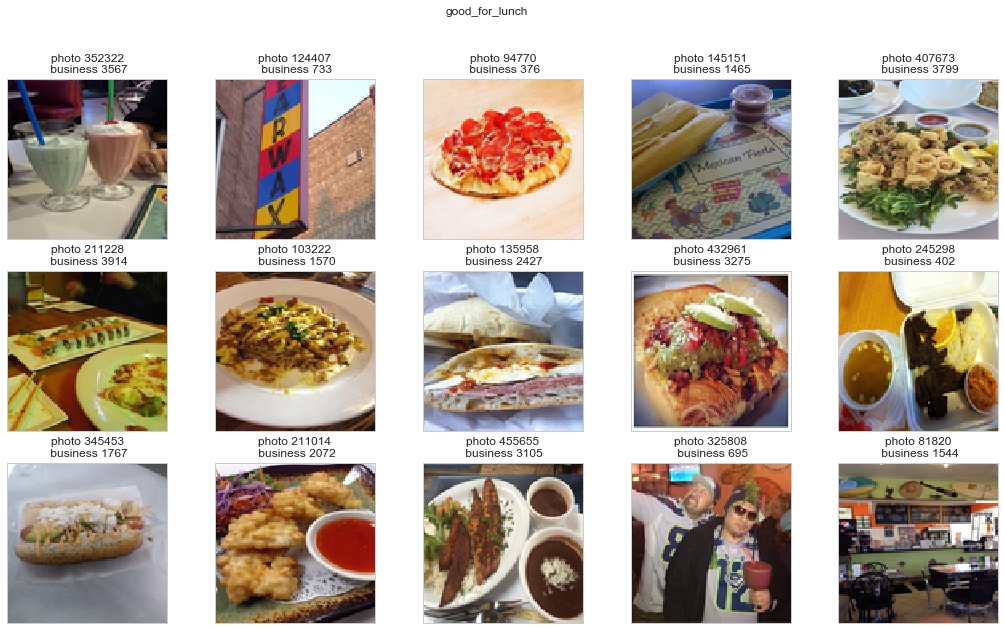

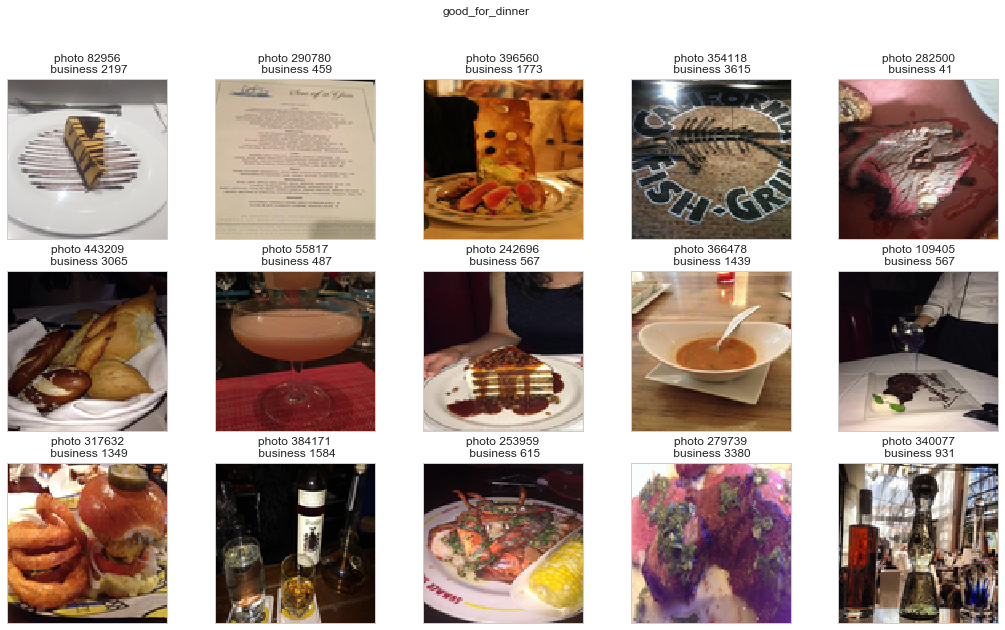

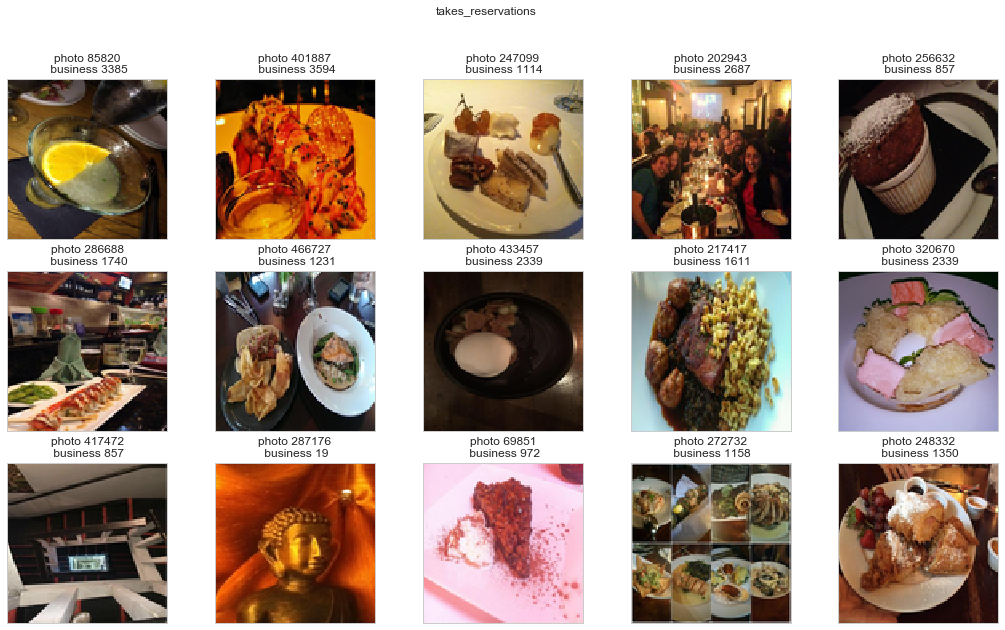

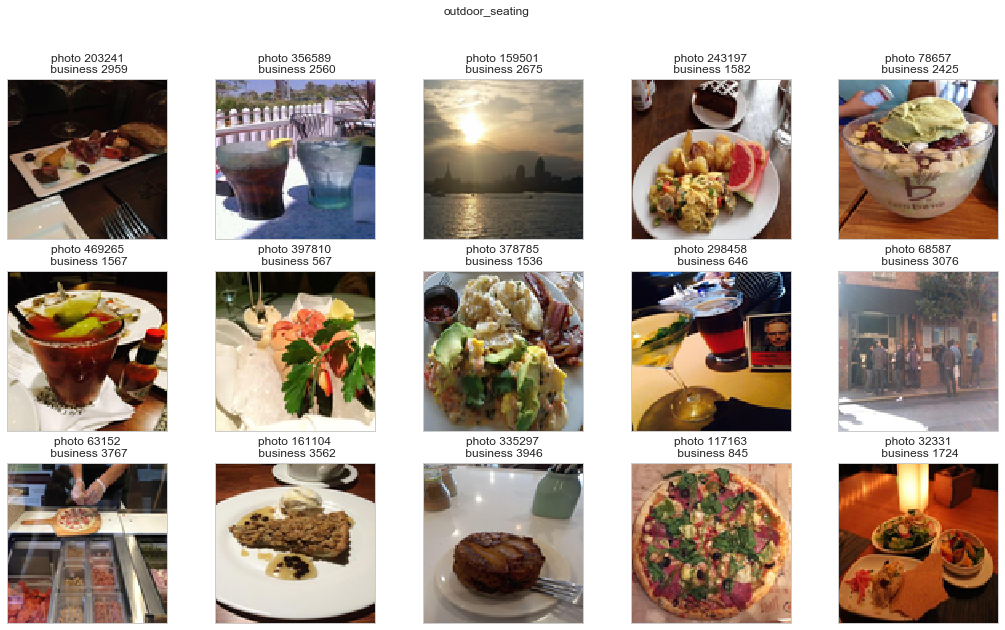

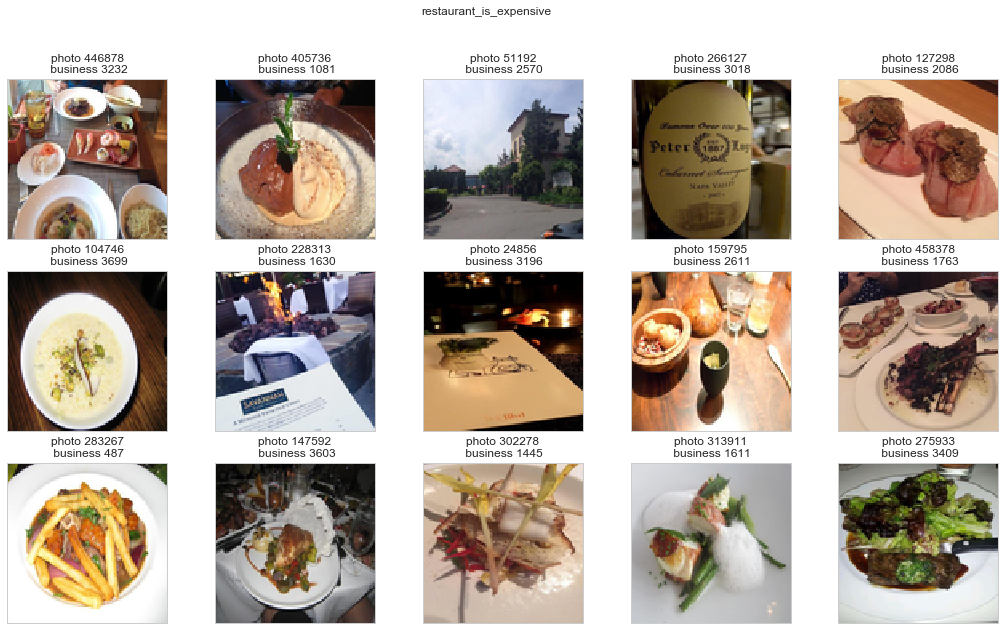

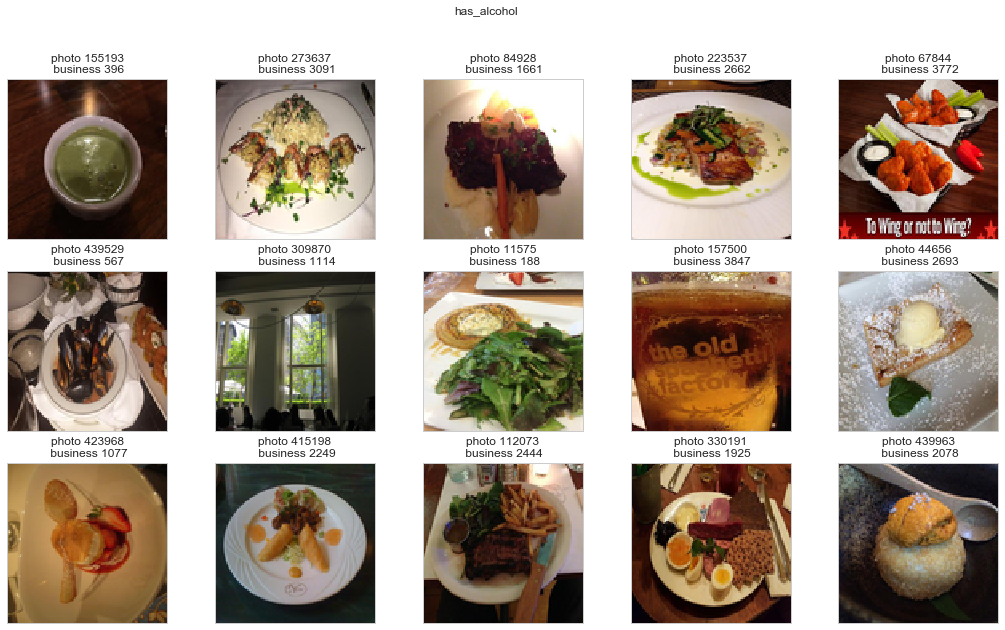

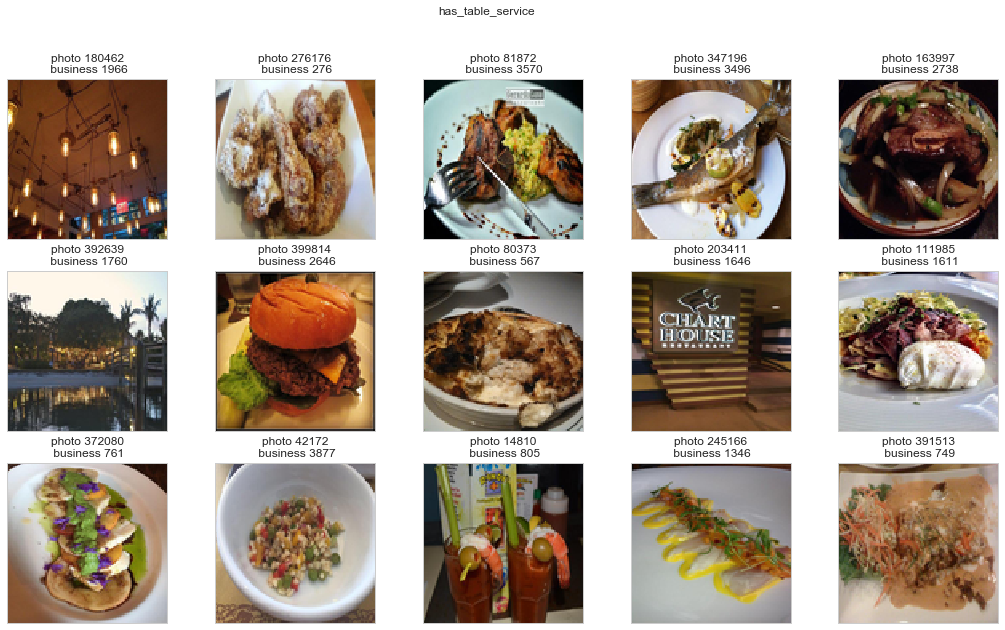

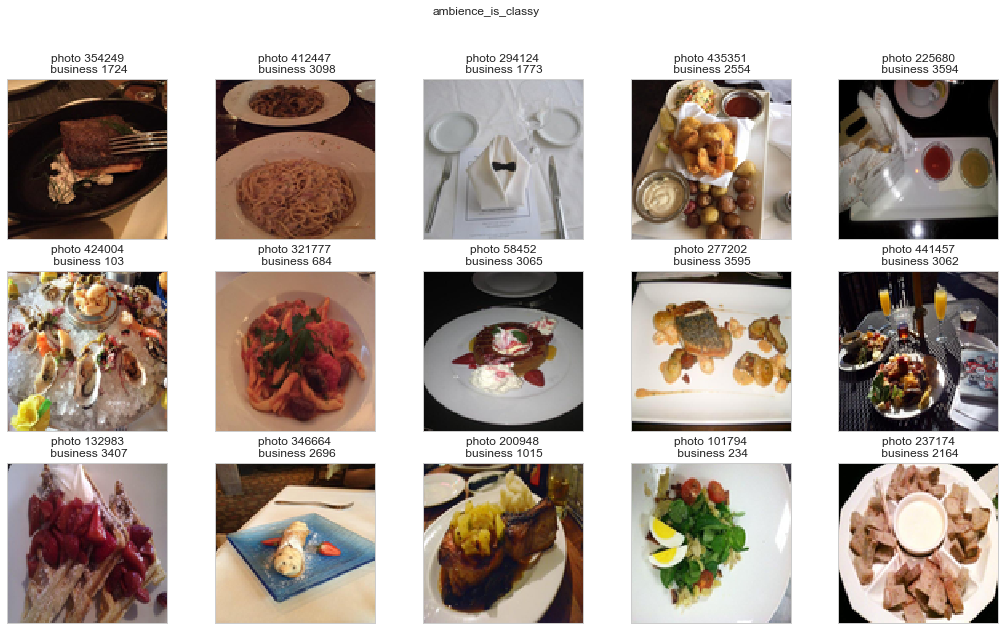

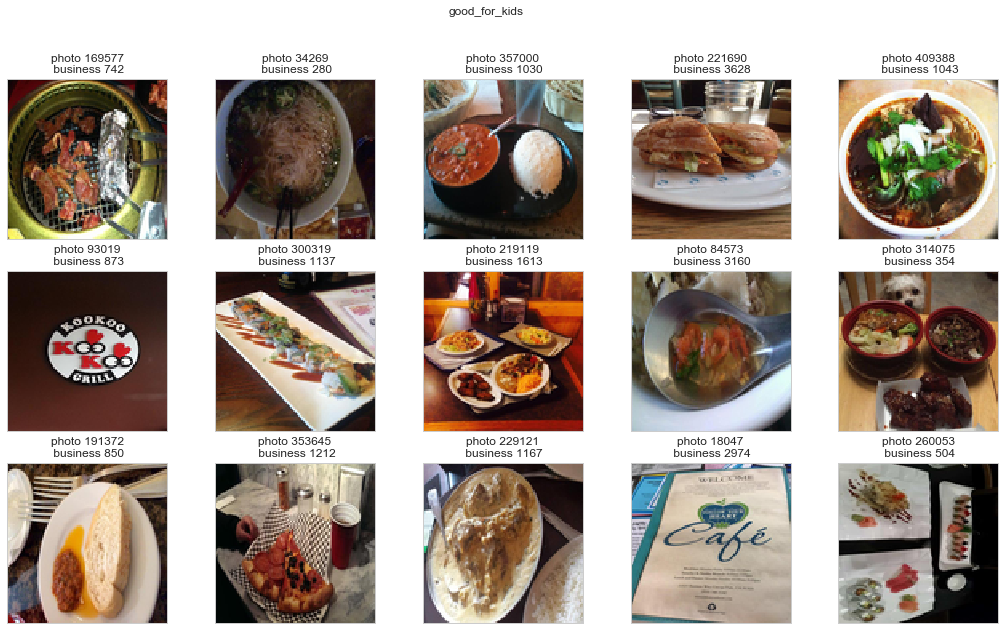

In [10]:
nImage = 15

for l, v in labels.items():
    photo_ids = np.random.choice(np.hstack(df[df['labels'].apply(lambda x: l in map(str,x))]['photos']), nImage)
    fig = plt.figure(figsize = (18,10))
    fig.suptitle(v)
    biz_ids = [list(photo2biz_train.loc[photo2biz_train['photo'] == i, 'business'])[0] for i in photo_ids]
    for i in range(len(photo_ids)):
        img = Image.open('data/train_photos/' + str(photo_ids[i]) + '.jpg')
        img = img.resize((100, 100), Image.ANTIALIAS)
        ax = fig.add_subplot(3, 5, i+1, xticks = [], yticks = [])
        ax.set_title('photo ' + str(photo_ids[i]) + '\n business ' + str(biz_ids[i]))
        ax.imshow(img)